In [182]:
import matplotlib
matplotlib.use('Agg')
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import feature, io, filters, measure, color, exposure, segmentation, morphology
from skimage.filters import rank
from skimage.morphology import watershed, disk, reconstruction
from scipy.misc import toimage
from scipy import ndimage as ndi
from sklearn.cluster import k_means
from itertools import compress
import h5py
import datetime
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1403: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Functions

In [183]:
def normalise(inData):
    """
    Normalise array.
    """
    inDataAbs = np.fabs(inData)
    inDataMax = np.amax(inData)
    normalisedData = inDataAbs/inDataMax
    return normalisedData

def cutArr(A):
    """
    Remove rows and columns of zero from input arr A.
    """
    A = A[:,~np.all(A == 0, axis=0)]
    A = A[~np.all(A == 0, axis=1)]
    return A
    
def resizeArray(arr):
    """
    Interpolate array to fit (200,200).
    """

    outArr = np.zeros((200,200))

    # Resize the arr
    ratio = 200.0/np.amax(arr.shape)

    arr = ndi.interpolation.zoom(arr, (ratio))
    outArr[:arr.shape[0],:arr.shape[1]] = arr
    return normalise(outArr)

def genExample(cell):
    cell = cutArr(cell)
    
    vacuoles, mpeaks = getVacuholes(cell)
    vacuoleLabels = measure.label(mpeaks)
        
    return cell, np.ma.masked_array(cell, mpeaks), \
      vacuoleLabels

def getVacuholes(cell):
    """
    Get vacuoles using skimage.morphology.construction()
    """
    seed = np.copy(cell)
    seed[1:-1, 1:-1] = cell.max()
    mask = cell

    filled = reconstruction(seed, mask, method='erosion')

    thresh = filters.threshold_mean(filled-cell)
    mask = (filled-cell) >= thresh
    mask = morphology.remove_small_objects(mask, 100)
    labeled = measure.label(mask)

    vacuoles = ndi.find_objects(labeled)
    
    return np.array(filter(None,vacuoles)), mask

## Find cell locations

In [184]:
uvimg = "./data/H - 11(fld 07 wv UV - DAPI).tif"
redimg = "./data/H - 11(fld 07 wv Red - Cy5).tif"

print("Markers from", uvimg, "Cells from", redimg)

imUV = io.imread(uvimg)
thresh = filters.threshold_li(imUV)
mask = imUV <= thresh
labeled = measure.label(mask, background=1)
markers = rank.median(labeled, disk(25))

imBW = io.imread(redimg)
p0, p1 = np.percentile(imBW, (10, 70)) # These parameters can also be changed
imBWrescaled = exposure.rescale_intensity(imBW, in_range=(p0, p1))
thresh = filters.threshold_li(imBWrescaled)
mask = imBWrescaled <= thresh
gradient = rank.gradient(mask==0, disk(2))

labeled = segmentation.watershed(gradient, markers)
labeled = segmentation.clear_border(labeled) # Get rid of border cells

cells = filter(None, ndi.find_objects(labeled))

cellImages = np.zeros((1,200,200))
cellImagesRAW = []
print("Cells found:", len(cells))
if len(cells) != 0:
    for i in np.arange(len(cells)):
        # Append cells to master list
        cellImagesRAW.append(imBW[cells[i]])
        cellImages = np.append(cellImages, resizeArray(imBW[cells[i]])[np.newaxis,...], axis=0)
cellImages = cellImages[1:]

('Markers from', './data/H - 11(fld 07 wv UV - DAPI).tif', 'Cells from', './data/H - 11(fld 07 wv Red - Cy5).tif')
('Cells found:', 55)


In [185]:
# This sometimes works, sometimes doesn'y, depending on whether the cellfinder picks up duds or not

#X_kmeans = k_means(np.reshape(cellImages,[-1,200*200]), 2, n_init=50) ## This looks like it works!!
#unique, counts = np.unique(X_kmeans[1], return_counts=True)
#print(dict(zip(unique, counts)))
#blueCells = np.argmax(counts) # This is where the hole cells are likely to be
#yellowCells = np.argmin(counts) # This is where the non-hole cells / noise are likely to be
#blueMask = X_kmeans[1] == blueCells
#yellowMask = X_kmeans[1] == yellowCells
#blueMask = np.ones(cellImages.shape[0])== 1

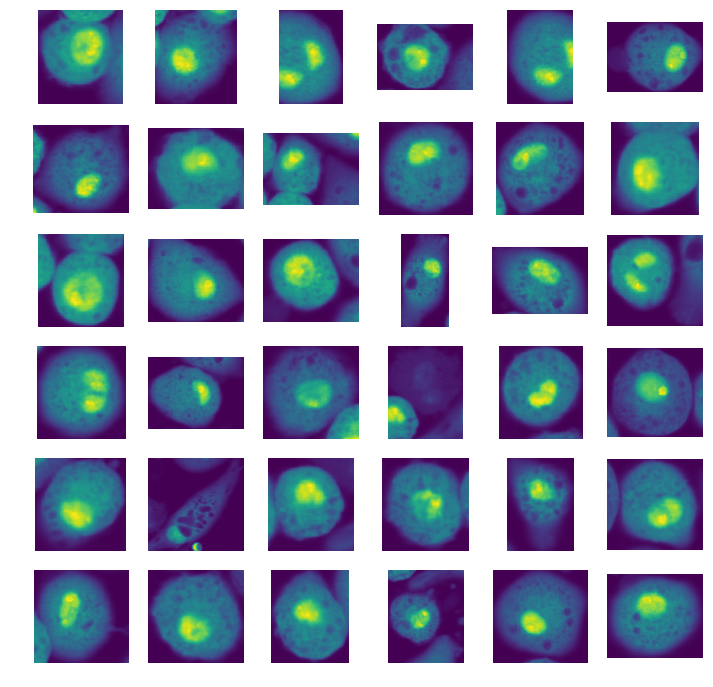

In [186]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(12,12))
j = 0
for i in ax.ravel():
    i.imshow(cutArr(cellImagesRAW[j]))
    j = j+1
    i.axis("off")

## Find vacuole locations

In [187]:
vacuoleArr = []
maskArr = []
for cell in cellImagesRAW:
    ind, mask = getVacuholes(cell)
    vacuoleArr.append(ind)
    maskArr.append(mask)

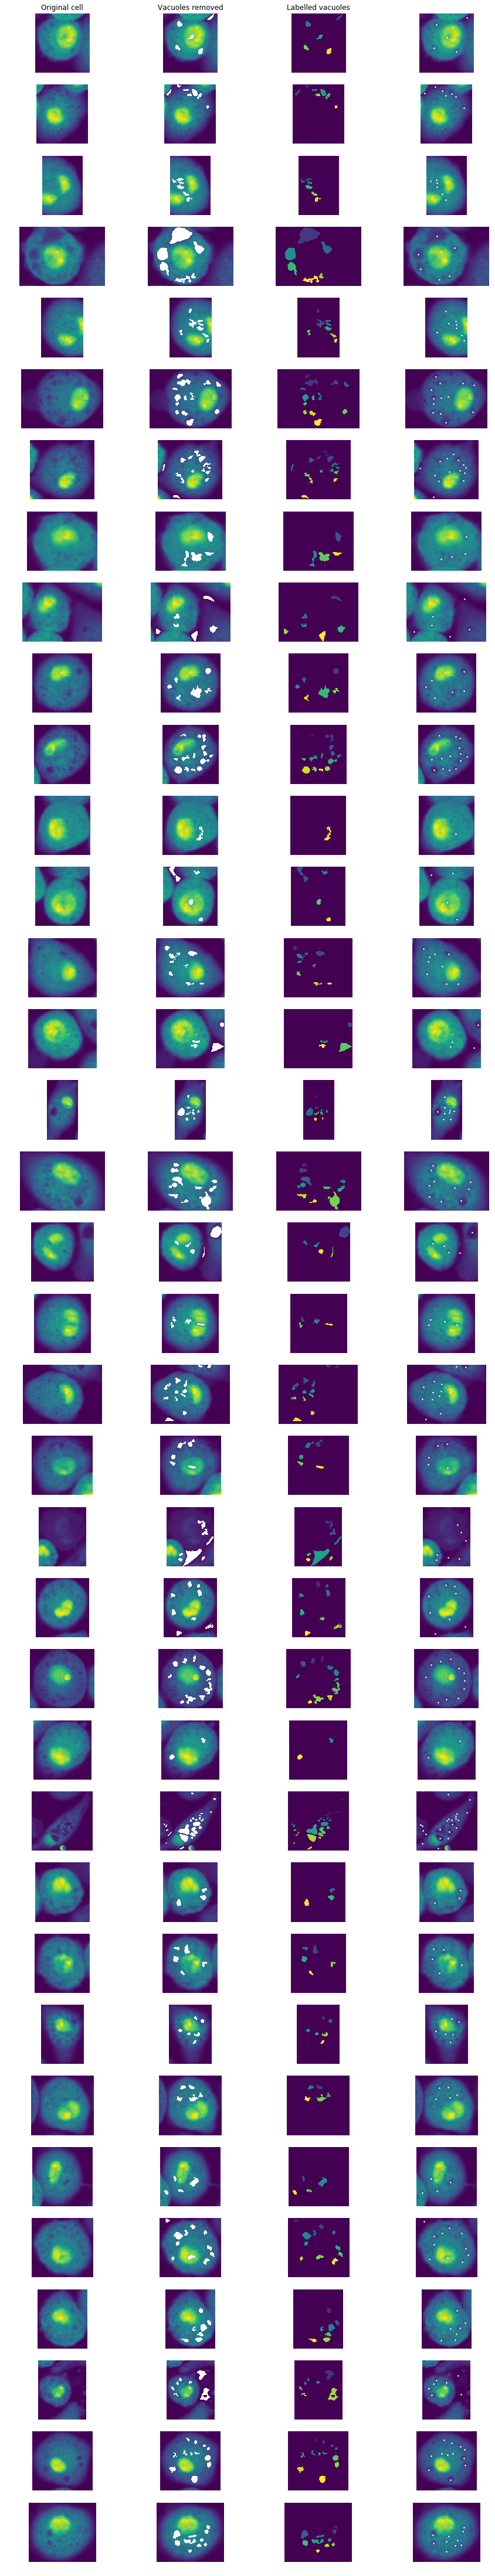

In [146]:
dt = str(datetime.datetime.now().replace(second=0, microsecond=0).isoformat("_"))

fig, ax = plt.subplots(ncols=4,nrows=36,figsize=(15,80))
for j in ax.ravel():
    j.axis("off")
ax[0,0].set_title("Original cell")  
ax[0,1].set_title("Vacuoles removed")
ax[0,2].set_title("Labelled vacuoles")
#plt.tight_layout()

for i in np.arange(36):
    a,b,c = genExample(cellImagesRAW[i])
    
    ax[i,0].imshow(a)
    ax[i,1].imshow(b)
    ax[i,2].imshow(c)
    ax[i,3].imshow(a)
    vacs = ndi.label(c)
    for j in np.arange(len(vacuoleArr[i])):
        avgvx = int(np.mean((vacuoleArr[i][j,0].start,vacuoleArr[i][j,0].stop)))
        avgvy = int(np.mean((vacuoleArr[i][j,1].start,vacuoleArr[i][j,1].stop)))
        ax[i,3].scatter(avgvy,avgvx,s=10,marker='.',c="white")   

## Get an example image with vacuole locations and cells highlighted

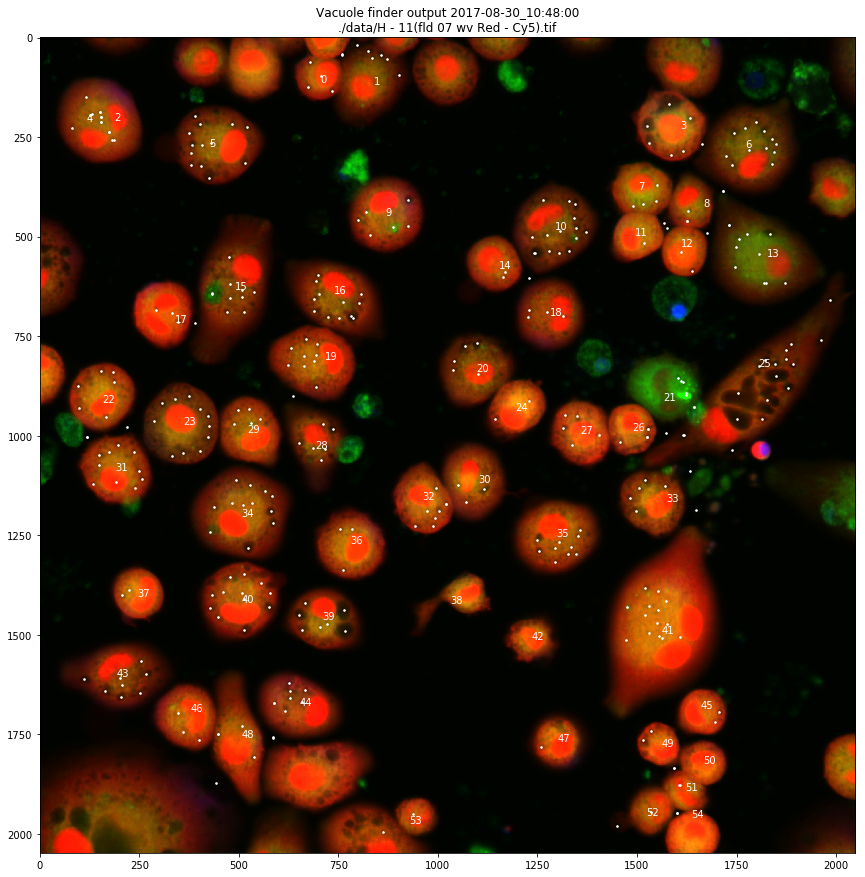

In [178]:
dt = str(datetime.datetime.now().replace(second=0, microsecond=0).isoformat("_"))

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(15,15))
cells = np.array(cells)
r = io.imread("./data/H - 11(fld 07 wv Red - Cy5).tif")
g = io.imread("./data/H - 11(fld 07 wv Green - dsRed).tif")
b = io.imread("./data/H - 11(fld 07 wv Blue - FITC).tif")

arr = np.dstack([r, g, b])
img = toimage(arr)
imBright = img.point(lambda p: p * 3) # Make each pixel brighter
plt.imshow(imBright)

plt.title("Vacuole finder output "+dt+"\n"+redimg)
#ax.axis("off")

cellData = []
vacData = []

for i in np.arange(np.shape(cells)[0]):      
    avgx = int(np.mean((cells[i,1].start,cells[i,1].stop)))
    xst = cells[i,1].start
    avgy = int(np.mean((cells[i,0].start,cells[i,0].stop)))
    yst = cells[i,0].start
    cellSize = abs((cells[i,0].stop-cells[i,0].start)*(cells[i,1].stop-cells[i,1].start))
    noVacs = len(vacuoleArr[i])
    cellData.append([i,int(avgx),int(avgy),int(cellSize),noVacs])
    
    for j in np.arange(len(vacuoleArr[i])):
        avgvx = int(np.mean((vacuoleArr[i][j,1].start,vacuoleArr[i][j,1].stop)))
        avgvy = int(np.mean((vacuoleArr[i][j,0].start,vacuoleArr[i][j,0].stop)))
        vacSize = abs((vacuoleArr[i][j,0].stop-vacuoleArr[i][j,0].start)*(vacuoleArr[i][j,1].stop-vacuoleArr[i][j,1].start))
        vacData.append([i,int(xst+avgvx),int(yst+avgvy),int(vacSize)])
        plt.scatter(xst+avgvx,yst+avgvy,s=10,marker='.',c="white")
        
    plt.annotate(str(i),xy=(avgx,avgy),color="white")

np.savetxt("./logs/"+dt+"_cellData", cellData, fmt="%i", delimiter=",", header=redimg+"\ncellNo,xcoord,ycoord,size,noVacuoles")
np.savetxt("./logs/"+dt+"_vacuoleData", vacData, fmt="%i", delimiter=",", header=redimg+"\ncellNo,xcoord,ycoord,size")
#plt.savefig("./figures/output/"+dt+"_outputExampleRGB.png")